# Ajustando um modelo SIR a uma epidemia de Influenza

In [1]:
using DifferentialEquations
using Random
using Distributions: Normal, MvNormal
using Statistics
using LsqFit
using Optim
using Plots
using Images

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1342


* Vamos, agora, ajustar os parâmetros $\beta$ e $\gamma$ do modelo SIR aos dados de uma epidemia de Influenza em um escola de meninos (internato) no norte da Inglaterra.

* Em um total de 763 residentes, em um período de duas semanas, o número de infectados a cada dia é dado pela lista
$$ \text{Infectados a partir do dia três} = [25, 75, 228, 297, 259, 235, 192, 126, 71, 28, 9, 7].
$$

* Fonte: Brauer & Castillo-Chavez (2012).

* Há uma lista um pouco diferente de infectados, que inclui desde, o dia da primeira ocorrência:
$$ \text{Infectados a partir do dia zero} = [1, 3, 7, 25, 72, 222, 282, 256, 233, 189, 123, 70, 25, 11, 4].
$$

* Fonte: Ledder(2013)

* Vamos usar, abaixo, os primeiros dados, de Brauer & Castillo-Chavez (2012).

## Ajuste

* Nesse caso, o modelo nos dá, a partir dos dados iniciais e dos parâmetros, uma solução $(S(t), I(t), R(t))$.

* Mas só temos dados dos números de infectados $I_j$, a cada dia $j=0, \ldots, 14$.

* Assim, a nossa função objetivo só pode ser construída em cima de $I(t)$ e dos dados $(t_j, I_j)$.

* Em algumas situações, as próprias condições iniciais também podem entrar como parâmetros a serem ajustados, mas no caso mais controlado acima, vamos fixar as seguinte condições iniciais:
  * $I(0) = I_j = 1$ residente;
  * $S(0) = 763 - 1 = 762$ residentes; e
  * $R(0) = 0$ residentes.

* Definimos a taxa de evolução do sistema $(S,I)$ do modelo SIR:

In [2]:
# Data from Brauer & Castillo-Chavez (2012)
N = 763
dias_amostra = [3:14...]
infectados_amostra = [25, 75, 228, 297, 259, 235, 192, 126, 71, 28, 9, 7]

# Data from Ledder
#dias_amostra = [1:15...]
#infectados_amostra = [1, 3, 7, 25, 72, 222, 282, 256, 233, 189, 123, 70, 25, 11, 4]

nothing

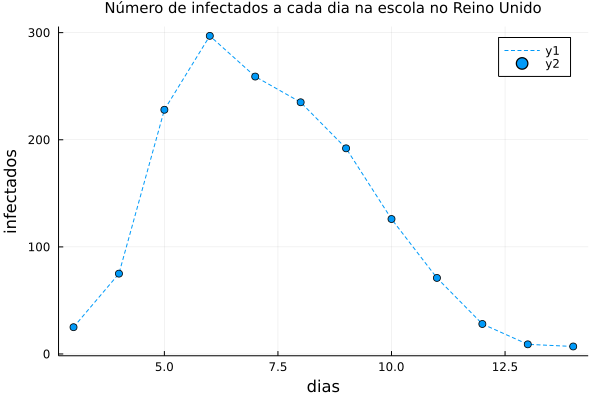

In [3]:
plot(dias_amostra, infectados_amostra, linestyle=:dash)
scatter!(dias_amostra, infectados_amostra, color=1)
plot!(xlabel="dias", ylabel="infectados",
    title="Número de infectados a cada dia na escola no Reino Unido", titlefont=10)

## Chute inicial dos parâmetros

* Observe que a epidemia cresce e decresce rapidamente, sugerindo uma alta taxa de transmissão e um curto tempo de recuperação.

* Por conta disso, vamos chutar, inicialmente, os seguintes valores dos parâmetros:
  * $\beta =  1.5$
  * $\gamma = 0.5$ (dois dias de recuperação)
  * $\mathcal{R} = \beta/\gamma = 3.0$

In [4]:
ρ₀ = [1.5, 0.5]
u₀ = [N-1, 1]
tspan = (0.0, 14.0)

(0.0, 14.0)

In [5]:
function dudt_SIR!(du, u, p, t)
    β, γ = p
    S, I = u
    R = N - S - I
    I_nov = β * I * S / N # novos infectados
    du[1] = - I_nov
    du[2] = I_nov - γ * I
end

dudt_SIR! (generic function with 1 method)

In [6]:
model(t, ρ) = solve(ODEProblem(dudt_SIR!, u₀, tspan, ρ), Tsit5())(t)[2]

model (generic function with 1 method)

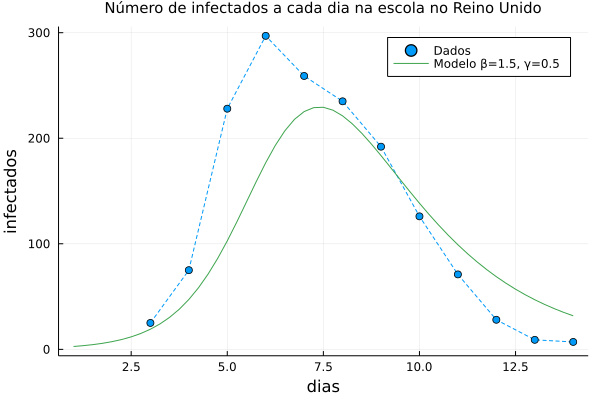

In [7]:
plot(dias_amostra, infectados_amostra, linestyle=:dash, label=false)
scatter!(dias_amostra, infectados_amostra, color=1, label="Dados")
tempos = 1.0:0.25:14.0
plot!(tempos, model.(tempos, Ref(ρ₀)), label="Modelo β=$(ρ₀[1]), γ=$(ρ₀[2])")
plot!(xlabel="dias", ylabel="infectados", legend=:topright,
    title="Número de infectados a cada dia na escola no Reino Unido", titlefont=10)

### Melhorando o chute inicial

* Podemos ajustar um pouco mais aumentando a taxa de transmissão:
  * $\beta =  1.8$ (taxa de contágio)
  * $\gamma = 0.5$ (dois dias de recuperação)
  * $\mathcal{R} = \beta/\gamma = 3.6$

In [8]:
ρ₀ = [1.8, 0.5]

2-element Vector{Float64}:
 1.8
 0.5

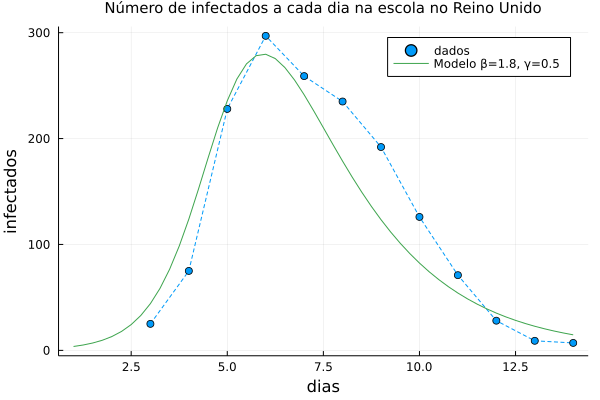

In [9]:
plot(dias_amostra, infectados_amostra, linestyle=:dash, label=false)
scatter!(dias_amostra, infectados_amostra, color=1, label="dados")
tempos = 1.0:0.25:14.0
plot!(tempos, model.(tempos, Ref(ρ₀)), label="Modelo β=$(ρ₀[1]), γ=$(ρ₀[2])")
plot!(xlabel="dias", ylabel="infectados", legend=:topright,
    title="Número de infectados a cada dia na escola no Reino Unido", titlefont=10)

* Assim parece mais próximo, mas vamos fazer o ajuste usando `LsqFit`, com esse novo chute inicial.

## Ajuste com LsqFit

In [10]:
fit = curve_fit((t,ρ) -> model.(t, Ref(ρ)), dias_amostra, infectados_amostra, ρ₀)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Int64}}([1.6682490524444034, 0.44168553876256506], [11.300152552044452, 26.713019152585133, -16.768304051845803, -9.563928727895473, 18.95762626672655, -11.59158349923564, -27.38697763847307, -9.670645128867264, 9.45437219094164, 26.983350935624017, 28.314915183534886, 18.21502077871589], [100.56001411318827 -104.13883134996215; 313.99595329228174 -345.1500044962695; … ; -75.41290846821784 -143.58068012563024; -53.65109932211391 -111.86828395224012], true, Int64[])

In [11]:
ρ = fit.param

2-element Vector{Float64}:
 1.6682490524444034
 0.44168553876256506

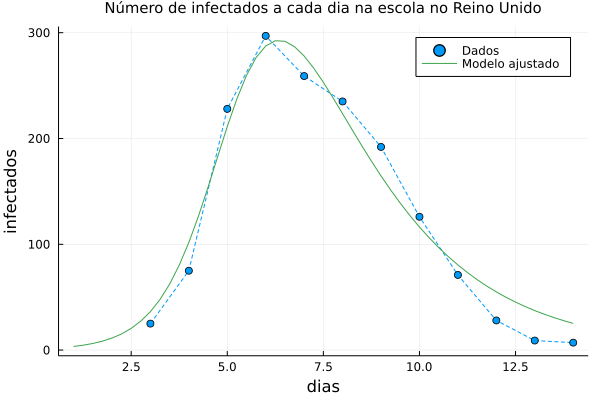

In [12]:
plot(dias_amostra, infectados_amostra, linestyle=:dash, label=false)
scatter!(dias_amostra, infectados_amostra, color=1, label="Dados")
tempos = 1.0:0.25:14.0
plot!(tempos, model.(tempos, Ref(ρ)), label="Modelo ajustado")
plot!(xlabel="dias", ylabel="infectados", legend=:topright,
    title="Número de infectados a cada dia na escola no Reino Unido", titlefont=10)

In [13]:
covar = estimate_covar(fit)

2×2 Matrix{Float64}:
 0.000861759  0.000194579
 0.000194579  0.000313972

## Outro chute inicial

* A escolha de um bom chute inicial é importante, como podemos ver na tentativa de ajuste abaixo, com outro chute inicial.

* Acabou achando os mesmos parâmetros, mas com mais dificuldade.

* Em outros casos, pode nem funcionar.

In [14]:
curve_fit((t,ρ) -> model.(t, Ref(ρ)), dias_amostra, infectados_amostra, [0.5, 0.2]).param

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /Users/rrosa/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
┌ Warn

2-element Vector{Float64}:
 1.6682490426075145
 0.44168553680672773

## Ajuste com o Optim

* Também podemos usar o `Optim`.

* Ele é mais flexível (mais liberdade na escolha e na construção da função custo).

* E costuma funcionar melhor.

* Ele só não nos dá, automaticamente, a matrix de covariância.

In [15]:
custo(ρ) = sum(abs2, infectados_amostra - model.(dias_amostra, Ref(ρ)))

custo (generic function with 1 method)

In [16]:
ρ₀ = [1.5, 0.5]
result = optimize(custo, ρ₀)

 * Status: success

 * Candidate solution
    Final objective value:     4.502256e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    71
    f(x) calls:    145


In [17]:
Optim.minimizer(result)

2-element Vector{Float64}:
 1.6682490469691573
 0.44168550942820095

## Propagação de incertezas

* Usando a matrix de covariância obtida com o `LsqFit`.

* E usando o método de Monte-Carlo.

* Podemos calcular os intervalos de confiança ao longo do tempo.

In [18]:
num_amostras = 200
parameters = rand(MersenneTwister(21001), MvNormal(ρ, covar), num_amostras)

2×200 Matrix{Float64}:
 1.65479  1.64094   1.64311   1.64178   …  1.65732   1.6368    1.64749
 0.46985  0.435592  0.429651  0.403384     0.418683  0.469833  0.456223

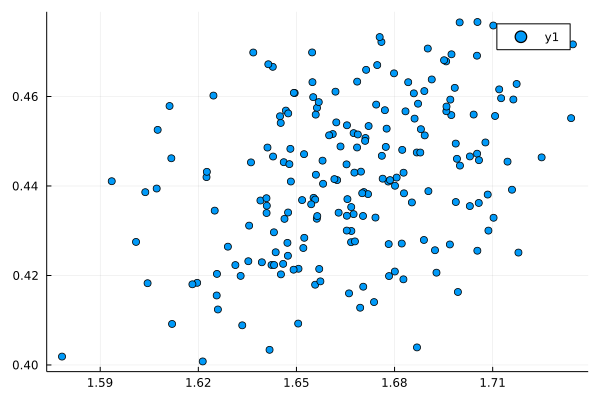

In [19]:
scatter(parameters[1,:], parameters[2,:])

### Incerteza

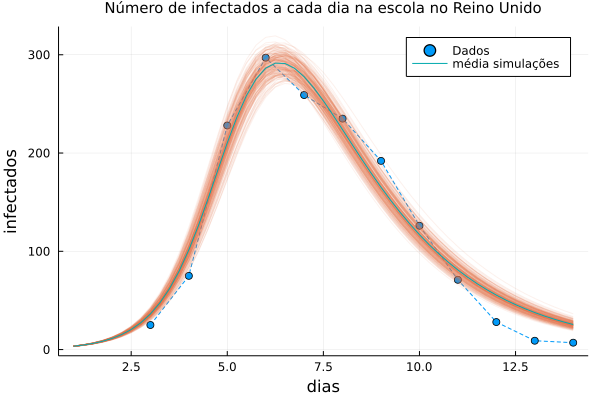

In [20]:
plot(dias_amostra, infectados_amostra, linestyle=:dash, label=false)
scatter!(dias_amostra, infectados_amostra, color=1, label="Dados")
tempos = 1.0:0.25:14.0
simulations = fill(0.0, length(tempos), num_amostras)
for n in 1:num_amostras
    ρ̃ = parameters[:,n]
    simulations[:,n] = model.(tempos, Ref(ρ̃))
    plot!(tempos, simulations[:,n], label=false, alpha=0.1, color=2)
end
plot!(tempos, mean(simulations, dims=2), color=6, label="média simulações")
plot!(xlabel="dias", ylabel="infectados", legend=:topright,
    title="Número de infectados a cada dia na escola no Reino Unido", titlefont=10)

## Exercícios


1. Considere o modelo SEIR e ajuste os seus parâmetros aos dados da escola do Reino Unido considerados no texto.

2. Idem para o modelo SIAR.

3. Idem para o modelo SEIAR.